In [1]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

from going_modular.custom_data_setup_main_train import LoadDataset
from going_modular import engine, utils
from going_modular import custom_data_setup_main_train
from going_modular.ThreeHeadCNN import ThreeHeadCNN
import helper_functions

c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [2]:
allow_train = True
load_pre_train_model = False
freeze_encoder = False
EPOCHS = 40
BATCH_SIZE = 128
shrink_size = 20

p = 0.1 # probability for augmentation
lr = 0.1
weight_deacay = 1e-4
T_max = 5
eta_min = 0.0

# weights for alpha is inverse frequency
alpha = torch.tensor([1/1805, 1/370, 1/999, 1/193, 1/295]) * 500 
gamma = 1

In [3]:
# Set matmul precision for TF32 usage on Ampere+ GPUs
# torch.set_float32_matmul_precision('medium')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Augmentation

In [4]:
A_transforms = helper_functions.get_augmentation_A_transforms(p)
no_transforms = helper_functions.get_augmentation_no_transforms()

In [5]:
# load all dataloaders

train_val_dataloader, class_names = custom_data_setup_main_train.create_train_val_dataloader(transform=A_transforms,
                                                                                        batch_size=BATCH_SIZE,
                                                                                        shrink_size=shrink_size) 
test_dataloader, class_names = custom_data_setup_main_train.create_test_dataloader(transform=no_transforms,
                                                                                        batch_size=BATCH_SIZE,
                                                                                        shrink_size=shrink_size)
exp_dataloader, class_names = custom_data_setup_main_train.create_train_dataloader(transform=no_transforms, 
                                                                                        batch_size=BATCH_SIZE,
                                                                                        shrink_size=shrink_size) 

16
4
16
4
16
4


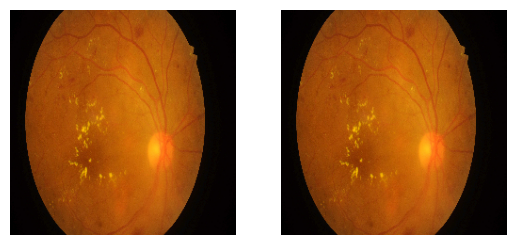

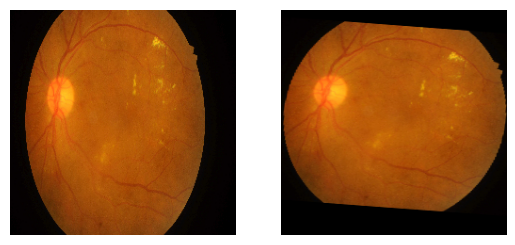

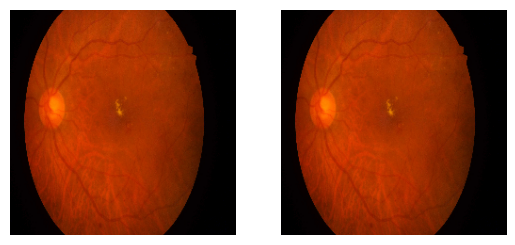

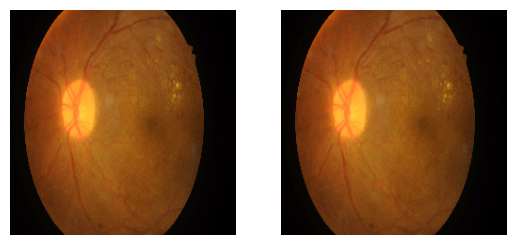

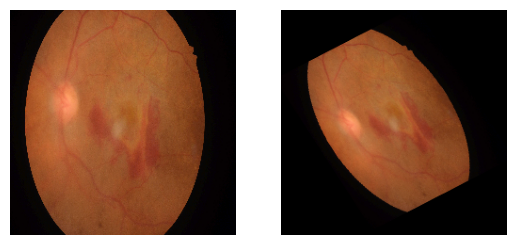

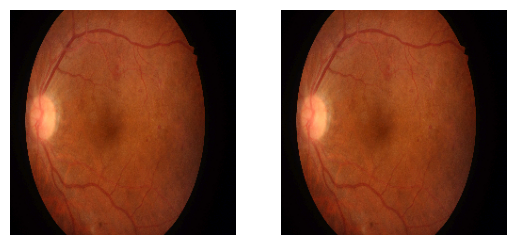

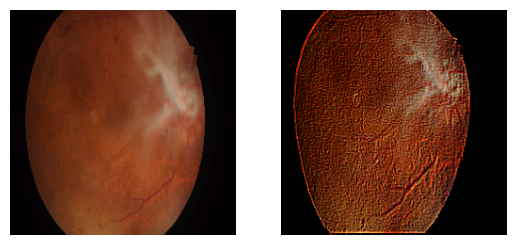

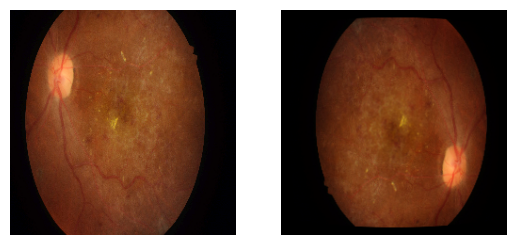

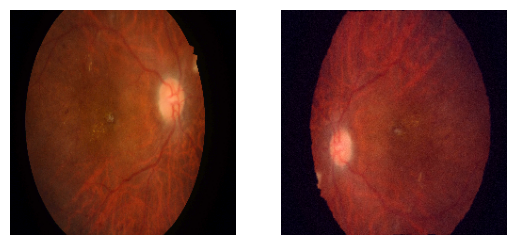

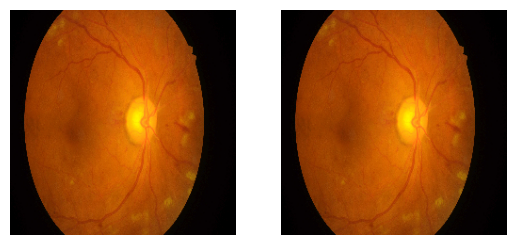

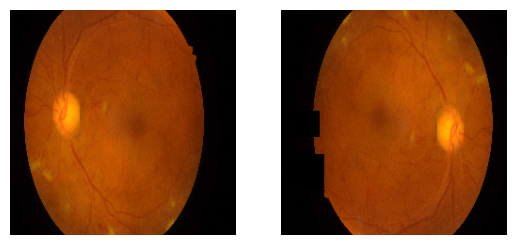

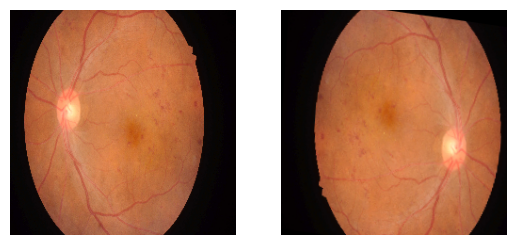

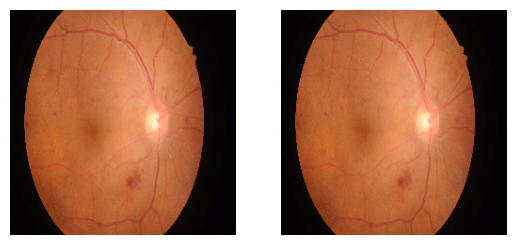

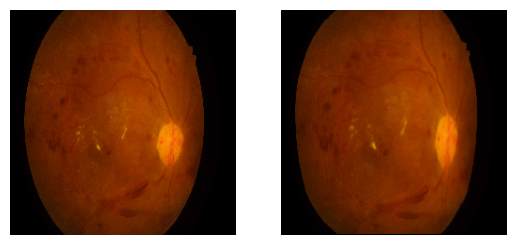

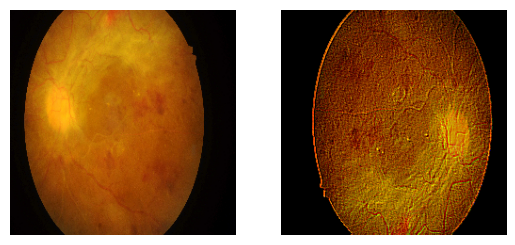

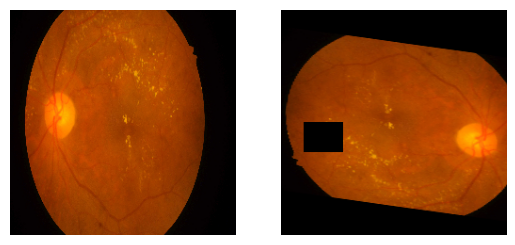

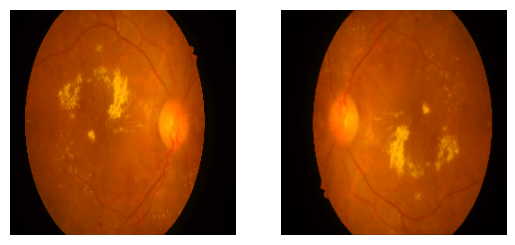

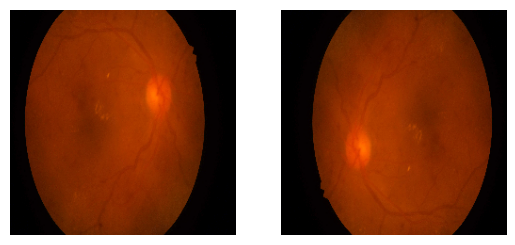

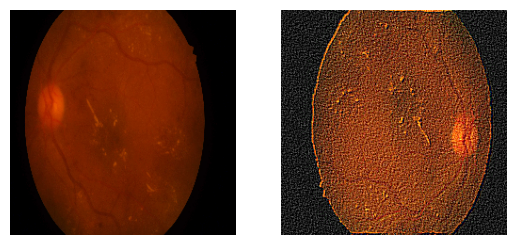

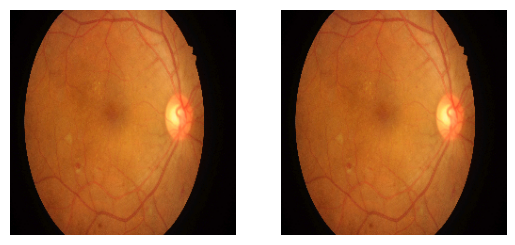

In [6]:
# plot some of the images to check applied augmentations

IDRID_image_folder = "../../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../../IDRID/idrid_labels.csv"  

test_dataset_with_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=A_transforms)
test_dataset_no_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)

for i in range(20):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()

In [7]:
model = ThreeHeadCNN().to(device)

In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
if freeze_encoder:
    for param in model.encoder.parameters():
        param.requires_grad = False

if load_pre_train_model:
    model.load_state_dict(torch.load("models/pre_train_model.pth", weights_only=True, map_location=device))

    # As the paper has stated, we reinitialize the heads weights
    model.classification_head = nn.Sequential(
                                nn.Linear(512, 128),
                                nn.ReLU(),
                                nn.Dropout(p=0.3),
                                nn.Linear(128, 5) # 5 output nodes for classification
                                )
    model.regression_head = nn.Sequential(
                                nn.Linear(512, 128),
                                nn.ReLU(),
                                nn.Dropout(p=0.3),
                                nn.Linear(128, 1) # 5 output nodes for classification
                                )
    model.ordinal_head = nn.Sequential(
                                nn.Linear(512, 128),
                                nn.ReLU(),
                                nn.Dropout(p=0.3),
                                nn.Linear(128, 5) # 5 output nodes for classification
                                )

In [9]:
# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(model=model, 
        input_size=(32, 3, 240, 240), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ThreeHeadCNN (ThreeHeadCNN)                                  [32, 3, 240, 240]    [32, 5]              --                   True
├─Sequential (encoder)                                       [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 16, 120

Custom Focal Loss function

In [10]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha, gamma, headType=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.headType = headType
    def forward(self, inputs, targets):
        
        if self.headType == 'classification':
            ce_loss = F.cross_entropy(inputs, targets, reduction='none')
            # apply class weights
            # alpha is for the weight class, weights is the correct weight for each class and looks like this: tensor([a, b, c, d, a, ...])
            weights = self.alpha.gather(0, targets)

        if self.headType == 'ordinal':
            ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
            # apply class weights
            # alpha is for the weight class, weights is the correct weight for each class and looks like this: tensor([a, b, c, d, a, ...])
            weights = self.alpha

        pt = torch.exp(-ce_loss)
        loss = (weights * ((1 - pt) ** self.gamma) * ce_loss)
        return loss.mean()

In [11]:
# Define loss and optimizer

# weights are selected based on the APTOS 2019 distribution according to the paper
# weights = torch.Tensor([3260/1750, 3260/270, 3260/840, 3260/140, 3260/260]) * 0.1
# weights.to(device)

# loss_fn_classification = nn.CrossEntropyLoss().to(device)
# loss_fn_classification = nn.CrossEntropyLoss(weight=weights).to(device)
loss_fn_classification = FocalLoss(headType='classification', alpha=alpha, gamma=gamma).to(device)

# loss_fn_regression = nn.L1Loss(reduction='none').to(device)
loss_fn_regression = nn.MSELoss().to(device)

# loss_fn_ordinal = nn.BCEWithLogitsLoss().to(device)
# loss_fn_ordinal = nn.BCEWithLogitsLoss(weight=weights).to(device)
loss_fn_ordinal = FocalLoss(headType='ordinal', alpha=alpha, gamma=gamma).to(device)

optimizer = torch.optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_deacay)
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

In [12]:
folds_train_results = {
    'loss_classification_train': [],
    'loss_regression_train': [],
    'loss_ordinal_train': []
}
folds_val_results = {
    'loss_classification_val': [],
    'loss_regression_val': [],
    'loss_ordinal_val': []
}
if allow_train:
    # Set the random seeds
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results
    for fold in train_val_dataloader:
        train_results, val_results = engine.train(model=model,
                            train_dataloader=fold['train_dataloader'],
                            val_dataloader=fold['val_dataloader'],
                            optimizer=optimizer,
                            scheduler=scheduler,
                            loss_fn_classification=loss_fn_classification,
                            loss_fn_regression=loss_fn_regression,
                            loss_fn_ordinal=loss_fn_ordinal,
                            epochs=EPOCHS,
                            device=device)
        
        folds_train_results['loss_classification_train'].extend(train_results['loss_classification_train'])
        folds_train_results['loss_regression_train'].extend(train_results['loss_regression_train'])
        folds_train_results['loss_ordinal_train'].extend(train_results['loss_ordinal_train'])

        folds_val_results['loss_classification_val'].extend(val_results['loss_classification_val'])
        folds_val_results['loss_regression_val'].extend(val_results['loss_regression_val'])
        folds_val_results['loss_ordinal_val'].extend(val_results['loss_ordinal_val'])

        helper_functions.plot_t_SNE(model=model,
                                dataloader=fold['val_dataloader'],
                                NUM_ITER=2000)

    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

    utils.save_model(model=model, target_dir='models', model_name='main_train_model.pth')
else:
    model.load_state_dict(torch.load('models/main_train_model.pth', weights_only=True, map_location=device))

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0
loss_classification_train: 2.2145 | loss_regression_train: 10.1272 | loss_ordinal_train: 0.4442
loss_classification_validation: 1.4782 | loss_regression_validation: 30.6807 | loss_ordinal_validation: 0.3688
acc_classification_validation: 0.2500 | acc_regression_validation: 0.7500 | acc_ordinal_validation: 0.0000

Epoch: 5
loss_classification_train: 1.1977 | loss_regression_train: 0.6732 | loss_ordinal_train: 0.4069
loss_classification_validation: 2.6198 | loss_regression_validation: 2.8018 | loss_ordinal_validation: 0.3506
acc_classification_validation: 0.2500 | acc_regression_validation: 0.7500 | acc_ordinal_validation: 0.0000



KeyboardInterrupt: 

In [ ]:
if allow_train:
    helper_functions.plot_loss_curves_main_train(folds_train_results, folds_val_results)

In [ ]:
test_results = engine.test_step(model=model,
            dataloader=exp_dataloader,
            loss_fn_classification=loss_fn_classification,
            loss_fn_regression=loss_fn_regression,
            loss_fn_ordinal=loss_fn_ordinal,
            device=device)

f1_class: tensor([0.7988, 0.0669, 0.4974, 0.0687, 0.3148]) | f1_reg: tensor([0.8237, 0.1508, 0.4898, 0.1089, 0.1963]) | f1_ord: tensor([0.8053, 0.1176, 0.4881, 0.0691, 0.2973])
test class acc: 0.6729932334266036 | test reg acc: 0.6687473095135601 | test ord acc: 0.6712948638613861
